In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import simulate
import seaborn as sns
import calculate_return as cr
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)
plt.style.use('seaborn')

In [3]:
spx = pd.read_csv('^GSPC.csv', index_col=0,parse_dates=True)

### Defining market to simulate

In [89]:
start = dt.date(2020, 1, 1)
end = dt.date(2060, 1, 1)
Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

Simulating data

In [ ]:
garch = Market.garch(log=False)
tdist = Market.t_innovations(log=False)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)
empirical=spx.iloc[-10437:, -2].pct_change().to_frame()

Plotting Returns

In [ ]:
f, ax1= plt.subplots(1, 1, figsize=(15,12))

ax1.plot(empirical['Adj Close'], alpha=.8)
ax1.set_ylabel('Yearly Returns')
ax1.set_ylim((-0.35,0.35))

In [ ]:
f, (ax1,ax2,ax3,ax4,) = plt.subplots(4, 1, figsize=(15,12))

ax1.plot(garch["Price"].pct_change(), alpha=.8)
ax1.set_ylabel('Yearly Returns')
ax1.set_ylim((-0.35,0.35))

ax2.plot(tdist['Price'].pct_change(), alpha=.8)
ax2.set_ylabel('Yearly Returns')
ax2.set_ylim((-0.35,0.35))

ax3.plot(norm['Price'].pct_change(), alpha=.8)
ax3.set_ylabel('Yearly Returns')
ax3.set_ylim((-0.35,0.35))

ax4.plot(draw['Price'].pct_change(), alpha=.8)
ax4.set_ylabel('Yearly Returns')
ax4.set_ylim((-0.35,0.35))

Plotting Histograms of returns

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#sns.kdeplot(data=garch['Price'].pct_change(),clip=(-0.1, 0.1),Label='GJR-GARCH(1,1)')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

#sns.kdeplot(data=tdist['Price'].pct_change(),clip=(-0.1, 0.1),Label='Skewed Students t-distribution')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

#sns.kdeplot(data=norm['Price'].pct_change(),clip=(-0.1, 0.1),Label='Normal distribution')
#sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

sns.kdeplot(data=draw['Price'].pct_change(),clip=(-0.1, 0.1),Label='Draw with Replacement')
sns.kdeplot(data=spx.iloc[-10437:, -2].pct_change(),clip=(-0.1, 0.1),Label='Empirical density')

plt.xlabel('Returns') 
plt.ylabel('Probability Density') 


In [ ]:
garch = Market.garch(log=False)
naive = Market.t_innovations(log=False)
draw = Market.draw(log = False, with_replacement = True, freq = 'D')
norm = Market.norm_innovations(log=False)

f, (ax1, ax2 , ax3) = plt.subplots(3, 1, figsize=(15,12))
ax1.plot(garch["Price"], alpha=.8)
ax1.plot(naive['Price'], alpha=.8)
ax1.plot(draw['Price'], alpha=.8)
ax1.plot(norm['Price'], alpha=.8)
ax1.set_title('Market')
ax1.legend(['garch', 'naive_t', 'draw with replace', 'naive_norm'])
ax1.set_yscale('log')

ax2.plot(garch["data"], alpha=.5)
ax2.plot(naive['Price'].pct_change()*100+20, alpha=.5)
ax2.plot(draw['Price'].pct_change()*100+40, alpha=.5)
ax2.plot(norm['Price'].pct_change()*100+60, alpha=.5)
ax2.set_ylim(-20, 80)
ax2.set_title('returns')
#ax2.set_yscale('LOG')

ax3.plot(garch["volatility"])
ax3.set_title('Volatility')
#ax3.set_yscale('LOG')

Simulating many markets

In [ ]:
def many_market(market, num_simulations):
    '''
    this simulated nobs markets with a horizon of years years

    return a dataframe with nobs columns and years*252 rows 
    '''
    data = pd.DataFrame()
    
    for i in range(num_simulations):
        data["Price_" + str(i)] = market.garch(log = True)['Price']
    return data

Descriptive statistic of simulations

In [ ]:
Market = simulate.Market(spx.iloc[-7500:, -2], start, end)
final_returns=many_market(Market, 1000).iloc[-1, :]

In [ ]:
plt.hist(final_returns, bins = 100, histtype='step', range=[-10000, 200000])
plt.show()

Plotting wealth with error

In [3]:
ports = cr.fetch_returns(sim_type = 'garch',
                         random_seeds = range(10000))

In [6]:
def plotter(Variable,n=1000,log=False):
    y = ports[[Variable]].sort_index()
    #Finder mean og std_afv per periode
    Data = y.groupby(level='period').mean()
    Data['std_dev']=y.groupby(level='period').std()
    Data=Data.rename(columns={Variable:'Mean'})

    #udregner øvre og nedre 95% confidens interval
    Data['Upper band']=Data['Mean']+1.96*Data['std_dev']/np.sqrt(n)
    Data['Lower band']=Data['Mean']-1.96*Data['std_dev']/np.sqrt(n)

    #plotting y with errorband +- error
    plt.plot(Data['Mean'],'-k')
    if log==True:
        plt.yscale('log')
    plt.fill_between(Data.index,Data['Lower band'], Data['Upper band'],alpha=0.5)
    

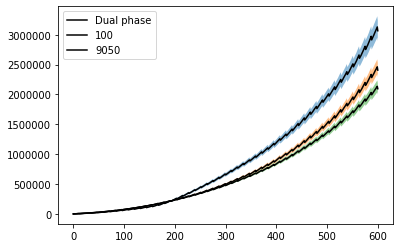

In [24]:
to_plot = ('Dual phase', '100', '9050')
for plot in to_plot:
    plotter(plot)
plt.legend(to_plot)
plt.show()

In [92]:
y = ports[["dual_phase","single_phase","100","9050"]].sort_index()
y = y.loc[(slice(None), '2070-01-01'),:]
quantile=y.quantile([0.1,0.25,0.5,0.75,0.9,0.99],axis=0).round(decimals=1)
quantile['dual_phase']=quantile['dual_phase'].apply('{:,}'.format)
quantile['100']=quantile['100'].apply('{:,}'.format)
quantile['9050']=quantile['9050'].apply('{:,}'.format)
print(quantile)


         dual_phase  single_phase          100         9050
0.100     513,075.0    539859.200    703,387.6    833,106.1
0.250   1,324,895.9   1360502.700  1,263,763.2  1,247,672.8
0.500   2,605,567.8   2613091.800  2,208,793.0  1,979,766.0
0.750   4,597,853.8   4486050.200  3,619,696.8  3,076,996.8
0.900   7,216,314.6   6904545.400  5,449,048.9  4,499,387.6
0.990  13,985,578.7  12990957.400  9,897,321.1  8,102,548.2


In [116]:
fige=y.copy()
fige['dual_phase'] = fige['dual_phase'].div(1000000) #Convert into millions
fige['single_phase'] = fige['single_phase'].div(1000000) #Convert into millions
fige['100'] = fige['100'].div(1000000) #Convert into millions
fige['9050'] = fige['9050'].div(1000000) #Convert into millions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.kdeplot(data=fige['dual_phase'],clip=(-1, 15),Label='Dual Phase')
sns.kdeplot(data=fige['single_phase'],clip=(-1, 15),Label='Single Phase')
sns.kdeplot(data=fige['100'],clip=(-1, 15),Label='All stock')
sns.kdeplot(data=fige['9050'],clip=(-1, 15),Label='Life cycle')
ax.set_xlabel('Returns (MM)') 
ax.ticklabel_format(style='plain', axis='x')
ax.set_ylabel('Probability Density',loc='top')
plt.savefig("C:\\Users\\caspe\\applied_finance\\Empirical\\density.png", bbox_inches = 'tight', pad_inches = 0.1)

AttributeError: 'Text' object has no property 'loc'

In [117]:
x = ports[["dual_phase","single_phase","100","9050"]]
x = x.rename(columns={'dual_phase':'Dual Phase','single_phase':'Single Phase','100': 'All stock', '9050': 'Life cycle'})
x = x.loc[(slice(None), '2070-01-01'),:]
x = pd.melt(x)
x['value'] = x['value'].div(1000000) #Convert into millions
f, ax = plt.subplots(figsize=(12,12))
ax = sns.boxplot(x='variable',y='value',data=x,showfliers = False,linewidth=2.5)
ax.set_ylabel("Terminal Value (MM)", rotation=0, loc='top', labelpad=-21) 
plt.xlabel("Strategy")
plt.ticklabel_format(style='plain', axis='y',useOffset=True)
plt.savefig("C:\\Users\\caspe\\applied_finance\\Empirical\\boxplot.png", bbox_inches = 'tight', pad_inches = 0.1)


AttributeError: 'Text' object has no property 'loc'

In [79]:
z = ports[['savings','cash','total_debt','pv_u','tv_u','dual_phase','single_phase','SU_debt','Nordnet_debt','market_returns']]
zz = z.loc[(slice(None), '2070-01-01'),:]
zzz = zz[zz['savings']==0].reset_index()#.sample(n=5)
defaulted=zzz['random_state'].tolist()
defaulted_df=z.loc[defaulted,:]

In [80]:
data=defaulted_df[['dual_phase','total_debt','market_returns']].reset_index().set_index('period')
data=data.groupby(['period']).mean()

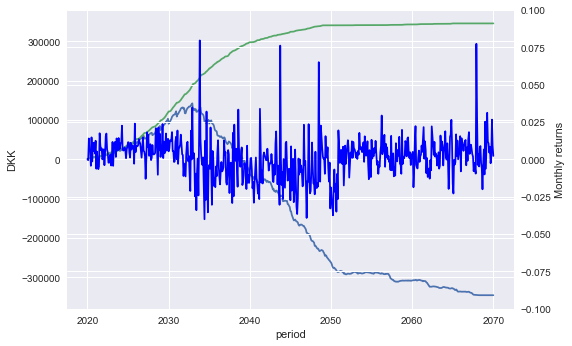

In [102]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data[['dual_phase','total_debt']])
ax2.plot(data[['market_returns']],color='b')
ax1.set_xlabel('period')
ax1.set_ylabel('DKK')
ax2.set_ylabel('Monthly returns')
ax2.set_ylim(-0.1,0.1)
plt.show()

In [46]:
fig = sns.lineplot(data = data, x='period', y='dual_phase', hue='random_state',legend=False)
fig.set(ylabel='Total Value',xlabel='Period')

ValueError: Could not interpret input 'period'

In [67]:
data

,random_state,dual_phase,total_debt,market_returns
period,,,,
2020-01-01,5585.500,450.000,450.000,0.000
2020-02-01,5585.500,822.990,907.000,-0.046
2020-03-01,5585.500,1547.509,1288.000,0.112
2020-04-01,5585.500,2274.333,2020.500,0.066
2020-05-01,5585.500,2829.453,2755.000,0.014
2020-06-01,5585.500,3082.309,3317.500,-0.029
2020-07-01,5585.500,3861.015,3638.000,0.041
2020-08-01,5585.500,4504.225,4364.500,0.017
2020-09-01,5585.500,5136.171,5015.500,0.014
